## Семинар 3 "Определение ключевых точек лица"

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [398]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
#from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline
import torchsample as ts
import time
import torch

In [399]:
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
# функция augm немного искажает и поворачивает изображения

def augm(X, angle_range=20, shear_range=10):

    for i in range(X.shape[0]):
        angle = (np.random.rand(1)[0]-0.5)*angle_range*2
        shear = (np.random.rand(1)[0]-0.5)*shear_range*2

        a1 = ts.transforms.Rotate(angle)(X[i])
        X[i] = ts.transforms.Shear(shear)(a1)
    return X

In [10]:
model = torch.nn.Sequential(
            torch.nn.Linear(784, 100),   
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
        )

In [11]:
# epochs = 10
# aug = False


def train(network, epochs, learning_rate, aug=False):

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            loss_fn = torch.nn.functional.nll_loss
            #optimizer =  torch.optim.SGD(network.parameters(), lr=learning_rate)
            optimizer =  torch.optim.Adam(network.parameters(), lr=learning_rate)

            for X, y in train_loader:

                if aug:
                    X = augm(X)


                X = torch.autograd.Variable(X)
                y = torch.autograd.Variable(y)
                X = X.view(X.shape[0], -1)


                y_pred = torch.nn.functional.log_softmax( network(X) )
                prediction = y_pred.data.numpy()

                optimizer.zero_grad()

                loss = loss_fn(y_pred, y)
                loss.backward()

                optimizer.step()

                loss_batch = float(loss.data)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y.data.numpy()).mean())

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []

            for X, y in test_loader:
                X = X.view(X.shape[0], -1)

                y = torch.autograd.Variable(y)
                X = torch.autograd.Variable(X)

                y_pred = torch.nn.functional.log_softmax( network(X) )
                prediction = y_pred.data.numpy()

                loss = loss_fn(y_pred, y)
                loss_batch = float(loss.data)

                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y.data.numpy()).mean())

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.5f}/{2:.5f}\tAccuracy: {3:.5f}/{4:.5f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))

    except KeyboardInterrupt:
        pass

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

/Users/evgeny/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/evgeny/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 5... (Train/Test) NLL: 0.33441/0.26363	Accuracy: 0.92128/0.93620

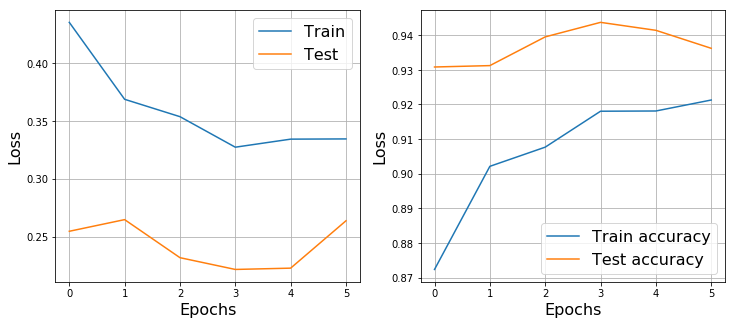

In [12]:
train(model, epochs=10, learning_rate=0.01, aug=True)